In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Load the data into a pandas DataFrame
# data = pd.DataFrame({
#     'title': ['Machine Learning for Beginners', 'The Future of Artificial Intelligence', 'Python for Data Analysis'],
#     'article': ['In this article, we will explore the basics of machine learning...', 'As AI technology continues to advance, experts weigh in on the potential impact...', 'This book provides a comprehensive guide to using Python for data analysis.'],
#     'author': ['John Doe', 'Jane Smith', 'Bob Johnson'],
#     'tags': ['machine learning', 'artificial intelligence', 'python', 'data analysis']
# })
data = pd.read_json('./data/youtube_history.json')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              2810 non-null   object
 1   title            2810 non-null   object
 2   visit_count      2810 non-null   int64 
 3   last_visit_time  2810 non-null   int64 
 4   publishedAt      2810 non-null   object
 5   description      2810 non-null   object
 6   channelTitle     2810 non-null   object
 7   channelId        2810 non-null   object
 8   tags             2162 non-null   object
dtypes: int64(2), object(7)
memory usage: 197.7+ KB
None


In [4]:
# Combine all the text features into a single column
data['text'] = data['title'] + ' ' + data['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else '')

In [50]:
# Create a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])

topic_count = 100

# Use Non-negative Matrix Factorization (NMF) to extract topics
nmf = NMF(n_components=topic_count, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Get the topic assignments for each row
topic_assignments = W.argmax(axis=1)

# Count the number of rows matched to each topic
topic_counts = [sum(topic_assignments == i) for i in range(topic_count)]

# Count the number of rows not matched to any topic
unmatched_count = sum(topic_assignments == -1)

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    topic_words = " ".join([feature_names[i] for i in topic.argsort()[:-11:-1]])
    print(f"Topic[{topic_idx}] {topic_counts[topic_idx]} matches: {topic_words}")
print(f"\nUnmatched Rows: {unmatched_count}")


Topic[0] 83 matches: comic book cleaning cgc comics age books golden label pressing
Topic[1] 70 matches: map fantasy cartography mountains making tutorial campaign tabletop mpa step
Topic[2] 9 matches: osr review rpg school old book reviews questing classics beast
Topic[3] 48 matches: dcs dogfight military war viper 22 raptor hornet air eagle
Topic[4] 55 matches: ai claude openai artificial agent intelligence engineer llm chatgpt api
Topic[5] 87 matches: book bookbinding binding library care adventures lessons collecting repair restoration
Topic[6] 75 matches: dune villeneuve lore denis herbert frank movie fremen bene arrakis
Topic[7] 32 matches: law lemon attorney lehtoslaw lehto www michigan http com steve
Topic[8] 49 matches: software web developer engineer humor programmer engineering programming development design
Topic[9] 24 matches: ansible semaphore devops rundeck training playbook tutorial inventory roles beginners
Topic[10] 12 matches: dice tray vault craft dnd book collectio

In [51]:
from sklearn.decomposition import NMF

# Try different numbers of topics
topic_nums = range(80, 150)
reconstruction_errors = []

for n_topics in topic_nums:
    nmf = NMF(n_components=n_topics, random_state=42,)
    W = nmf.fit_transform(X)
    reconstruction_errors.append(nmf.reconstruction_err_)

import matplotlib.pyplot as plt
plt.plot(topic_nums, reconstruction_errors)
plt.xlabel("Number of topics")
plt.ylabel("Reconstruction error")
plt.show()

In [ ]:
! pip install astrop

In [ ]:
from astropy.stats import akaike_info_criterion, bayesian_info_criterion

# Try different numbers of topics
aic_scores = []
bic_scores = []

for n_topics in topic_nums:
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(X.toarray())
    aic_scores.append(akaike_info_criterion(W, n_topics, X.shape[1])) 
    bic_scores.append(bayesian_info_criterion(W, n_topics, X.shape[1]))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(topic_nums, aic_scores)
plt.xlabel("Number of topics")
plt.ylabel("AIC score")
plt.subplot(1, 2, 2)
plt.plot(topic_nums, bic_scores)
plt.xlabel("Number of topics")
plt.ylabel("BIC score")
plt.show()

[nltk_data] Downloading package punkt to /home/anvil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


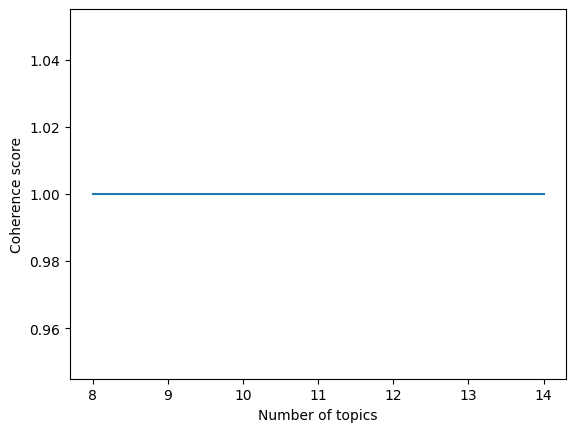

In [41]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

data['tokens'] = data['text'].apply(word_tokenize)

# Create a dictionary from the tokenized text
dictionary = Dictionary(data['tokens'].tolist())

coherence_scores = []

for n_topics in topic_nums:
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(X)
    coherence_model = CoherenceModel(topics=H, texts=data['text'], dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

plt.plot(topic_nums, coherence_scores)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.show()

In [11]:
# Determine the user's preferred topics
user_topic_prefs = W[0].argsort()[-3:]

print("\nUser's preferred topics:")
for topic_idx in user_topic_prefs:
    print(f"Topic {topic_idx}: {' '.join([feature_names[i] for i in H[topic_idx].argsort()[:-11:-1]])}")


User's preferred topics:
Topic 2: dnd rpg dragons dungeons dm the and dice to master
Topic 3: dcs dogfight military war world viper raptor 22 air hornet
Topic 4: ai software web agents engineer engineering development programming crewai agent
